# EDA for the HSSC paper

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Table-of-Questions" data-toc-modified-id="Table-of-Questions-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Table of Questions</a></span></li><li><span><a href="#Library-imports" data-toc-modified-id="Library-imports-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Library imports</a></span></li><li><span><a href="#Data-imports" data-toc-modified-id="Data-imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Data imports</a></span></li><li><span><a href="#Functions" data-toc-modified-id="Functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Functions</a></span></li><li><span><a href="#Data-tranformations" data-toc-modified-id="Data-tranformations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Data tranformations</a></span><ul class="toc-item"><li><span><a href="#Date-from-string-to-date-format" data-toc-modified-id="Date-from-string-to-date-format-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Date from string to date-format</a></span></li><li><span><a href="#Replace-0s-by-1s-to-avoid-zero-division" data-toc-modified-id="Replace-0s-by-1s-to-avoid-zero-division-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Replace 0s by 1s to avoid zero division</a></span></li></ul></li><li><span><a href="#Analysis" data-toc-modified-id="Analysis-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Analysis</a></span><ul class="toc-item"><li><span><a href="#Sentence-length" data-toc-modified-id="Sentence-length-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Sentence length</a></span></li><li><span><a href="#Number-of-incentives" data-toc-modified-id="Number-of-incentives-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Number of incentives</a></span></li><li><span><a href="#Types-of-incentives" data-toc-modified-id="Types-of-incentives-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Types of incentives</a></span></li><li><span><a href="#Stats-by-country" data-toc-modified-id="Stats-by-country-6.4"><span class="toc-item-num">6.4&nbsp;&nbsp;</span>Stats by country</a></span></li></ul></li></ul></div>

## Table of Questions
[Sentence length](#Sentence-length)
  * Is there any pattern in the distribution of sentence length?
  * Is there any insight that we can draw from the analysis of the distribution of sentence length in relation with the sentence splitting process?
  
[Number of incentives](#Number-of-incentives)  
  * What is the absolute number of incentives?
  * What is the ratio of documents with incentives?
  * What is the average number of incentives per document?


## Library imports

In [1]:
import csv
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

from datetime import datetime as dt
from sklearn.metrics import r2_score


## Data imports

In [2]:
# Names of the columns in the database
col_names = ["id", "country", "pub lication_source", "issuing_institution", "doc_type", "date", "doc_title", "summary",
            "url", "num_sents", "min_sent_len", "max_sent_len", "avg_sent_len", "num_incentives_sbert", "supplies_sbert",
            "loan_sbert", "fine_sbert", "direct_payment_sbert", "technical_assistance_sbert", "tax_benefit_sbert",
            "num_incentives_bert", "supplies_bert", "loan_bert", "fine_bert", "direct_payment_bert", "technical_assistance_bert",
            "tax_benefit_bert"]

In [3]:
# Loading the two csv files and merging them toghether in a single dataframe.
in_path = "../input/"
files = [f"{in_path}spanish_metadata.csv", f"{in_path}english_metadata.csv"]

dfs = []

for filename in files:
    df_temp = pd.read_csv(filename, index_col=None, header=None)
    dfs.append(df_temp)

df = pd.concat(dfs, axis=0, ignore_index=True)
df.columns = col_names

In [4]:
# Execute it only if yo want to save the contents of the whole database into an excel file
out_path = "../output/"
file_name =  "metadata.xlsx"
df.to_excel(f"{out_path}{file_name}")

In [5]:
# Execute it only if you want to visualize the first 5 rows of the dataframe
df.head()

,id,country,pub lication_source,issuing_institution,doc_type,date,doc_title,summary,url,num_sents,...,direct_payment_sbert,technical_assistance_sbert,tax_benefit_sbert,num_incentives_bert,supplies_bert,loan_bert,fine_bert,direct_payment_bert,technical_assistance_bert,tax_benefit_bert
0,765d4ea2383aaf45bb29bf75feadea6e06a80fd2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Tamanique,27/01/2015,ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,"La presente Ordenanza tiene por objeto, promov...",https://www.jurisprudencia.gob.sv/DocumentosBo...,315,...,11,0,1,52,3,1,30,12,1,5
1,06dafc0a507e270d9b23b192489cb1012aed1a8f,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,01/02/2018,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,28,...,0,0,0,1,1,0,0,0,0,0
2,3416cbf9af02b66c40c8ee6f6aa5988ba680dcb2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Jocoro,21/08/2017,ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,La presente ordenanza tiene por objeto estable...,https://www.jurisprudencia.gob.sv/DocumentosBo...,228,...,1,4,1,26,4,0,20,0,1,1
3,485f9571c67f4a8009dd340bc5905f56a767b400,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,08/10/2014,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,30,...,0,0,0,0,0,0,0,0,0,0
4,2c1449a52f077b5b0d61471a55601f0a316be1a9,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-San José Villanueva,06/09/2012,ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,El objeto de la presente Ordenanza es el de no...,https://www.jurisprudencia.gob.sv/DocumentosBo...,29,...,2,0,0,4,0,0,1,1,0,2


In [5]:
# Execute it only of you want to ave a summary of the main descriptive statistics
df.describe()

,num_sents,min_sent_len,max_sent_len,avg_sent_len,num_incentives_sbert,supplies_sbert,loan_sbert,fine_sbert,direct_payment_sbert,technical_assistance_sbert,tax_benefit_sbert,num_incentives_bert,supplies_bert,loan_bert,fine_bert,direct_payment_bert,technical_assistance_bert,tax_benefit_bert
count,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000,22241.000000
mean,174.408884,65.205701,1481.993705,262.339193,4.541837,0.186592,0.940605,0.496246,1.938582,0.642822,0.336990,5.263208,0.288926,1.124725,0.522189,2.384155,0.637471,0.305742
std,456.602814,1499.307493,5065.627467,772.921029,22.578820,1.437637,10.604733,2.619774,11.354919,4.489930,1.692201,28.573664,2.006435,14.309902,3.090113,14.855040,4.976735,2.037232
min,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,17.000000,27.000000,658.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,45.000000,35.000000,830.000000,209.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,139.000000,46.000000,1319.000000,271.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
max,14656.000000,100000.000000,284859.000000,101915.000000,747.000000,70.000000,736.000000,78.000000,397.000000,252.000000,72.000000,1172.000000,73.000000,1152.000000,101.000000,594.000000,246.000000,96.000000


In [18]:
# Number of sentences
len(df)

22241

## Functions

In [12]:
# To transform dd/mm/yyyy dates in string format to yyyy/mm/dd or viceversa
def reorder_date(string):
    elements = string.split("/")
    return(f"{elements[2]}/{elements[1]}/{elements[0]}")
        
# To standardize all dates in string format and convert them to datetime format
def standardize_date(string):
    string = string.replace("-", "/").strip()
    if re.search(r"[\d]{2}/[\d]{2}/[\d]{4}", string):
        string = reorder_date(string)
    try:
        date = dt.strptime(string, '%Y/%m/%d')
        return date
    except:
        print(f"{string}")

# To calculate the confidence interval of a series of values
# The significance values can be only 0.05 or 0.01
# The two available methods are "ci_normal", "ci_not_normal" and "2xs"
def confidence_interval(significance_value, method, list_of_values):
    methods = {"ci_normal" : 0, "ci_not_normal" : 0, "2xs" : 0}
    significances = {0.05 : 0, 0.01 : 0}
    z_values = {0.05 : 1.92, 0.01 : 2.58}
    t_values_n10 = {0.05 : 2.92, 0.01 : 6.96}
    t_values_n20 = {0.05 : 2.05, 0.01 : 3.36}
    s = np.std(list_of_values)
    
    if method not in methods:
        print(f"ERROR! The method is not properly spelled or it is not available.\nPlease select one of: \"ci_normal\", \"ci_not_normal\" or \"2xs\"")
        return
    if significance_value not in significances:
        print(f"ERROR! ThThe choosen significance value is not available.\nPlease select one of: 0.05 or 0.01")
        return
    elif method == "2xs":
        return(2*s)
    else:
        if method == "ci_normal" or len(list_of_values) > 20:
            z = z_values[significance_value]
        if method == "ci_not_normal" and len(list_of_values) <= 20:
            if len(list_of_values) <= 10:
                z = t_values_n10[significance_value]
            elif len(list_of_values) <= 20:
                z = t_values_n20[significance_value]
        return(s * z / np.sqrt(len(list_of_values)))
            
            
        
    
    

def bins_labels(bins, **kwargs):
    bin_w = (max(bins) - min(bins)) / (len(bins) - 1)
    labels = [int(x) for x in bins[1:] - 1]
    labels = [int(x) for x in bins[1:]]
    plt.xticks(np.arange(min(bins)+bin_w/2, max(bins), bin_w), labels, **kwargs)
#     plt.xlim(bins[0], bins[-1])

## Data tranformations

### Date from string to date-format
The format of the date is not homogeneous on the date column\
The date is of type *string* which is not good for calculations

In the next couple of cells we will:
* Add a new column with the date in format datetime
* Standardize the date column to yyyy-mm-dd


In [13]:
# Inserting a new column called "date_time" containing the date as datetime type to easy calculations
df.insert(6, "date_time", df['date'].map(standardize_date))

In [14]:
# Transforming the date values to standardize them in the format yyyy-mm-dd
df["date"] = df["date_time"].dt.strftime("%Y-%m-%d")

### Replace 0s by 1s to avoid zero division

* As there are 5 documents with 0 sentences, we replace the num_sents value by 1 to avoid zero division
* We also replace all five values of "avg_sent_len" from 0 to 1

In [15]:
df["num_sents"].replace({0 : 1}, inplace = True)
df["avg_sent_len"].replace({0 : 1}, inplace = True)

In [16]:
df

,id,country,pub lication_source,issuing_institution,doc_type,date,date_time,doc_title,summary,url,...,direct_payment_sbert,technical_assistance_sbert,tax_benefit_sbert,num_incentives_bert,supplies_bert,loan_bert,fine_bert,direct_payment_bert,technical_assistance_bert,tax_benefit_bert
0,765d4ea2383aaf45bb29bf75feadea6e06a80fd2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Tamanique,2015-01-27,2015-01-27,ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,"La presente Ordenanza tiene por objeto, promov...",https://www.jurisprudencia.gob.sv/DocumentosBo...,...,11,0,1,52,3,1,30,12,1,5
1,06dafc0a507e270d9b23b192489cb1012aed1a8f,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,2018-02-01,2018-02-01,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,...,0,0,0,1,1,0,0,0,0,0
2,3416cbf9af02b66c40c8ee6f6aa5988ba680dcb2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Jocoro,2017-08-21,2017-08-21,ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,La presente ordenanza tiene por objeto estable...,https://www.jurisprudencia.gob.sv/DocumentosBo...,...,1,4,1,26,4,0,20,0,1,1
3,485f9571c67f4a8009dd340bc5905f56a767b400,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,2014-10-08,2014-10-08,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,...,0,0,0,0,0,0,0,0,0,0
4,2c1449a52f077b5b0d61471a55601f0a316be1a9,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-San José Villanueva,2012-09-06,2012-09-06,ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,El objeto de la presente Ordenanza es el de no...,https://www.jurisprudencia.gob.sv/DocumentosBo...,...,2,0,0,4,0,0,1,1,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22236,62776ad3af4f24f9edeedc1b905e1f0162a754fe,USA,Federal Register,DEPARTMENT OF TRANSPORTATION,Regulatory Information,2015-11-23,2015-11-23,U.S. Fish and Wildlife Service Long Range Tran...,"The Federal Highway Administration, along with...",https://api.govinfo.gov/packages/FR-2015-11-23...,...,0,0,0,0,0,0,0,0,0,0
22237,3f877d82c12ce711414b64c279f2eac20c5b84dc,USA,Federal Register,DEPARTMENT OF COMMERCE,Regulatory Information,2015-11-24,2015-11-24,Takes of Marine Mammals Incidental to Specifie...,"Upon application from the U.S. Navy (Navy), we...",https://api.govinfo.gov/packages/FR-2015-11-24...,...,1,4,0,7,5,0,0,1,1,0
22238,f77803758c02caac61094568614af3316f3a00e5,USA,Federal Register,DEPARTMENT OF HEALTH AND HUMAN SERVICES,Regulatory Information,2015-11-24,2015-11-24,Voluntary Labeling Indicating Whether Foods Ha...,The Food and Drug Administration (FDA or we) i...,https://api.govinfo.gov/packages/FR-2015-11-24...,...,0,0,0,1,0,0,0,1,0,0
22239,2ff8ba898fc584577c16a1e7023b68bca4f10ff2,USA,Federal Register,ENVIRONMENTAL PROTECTION AGENCY,Regulatory Information,2015-11-24,2015-11-24,Air Plan Approval; ME; Repeal of the Maine's G...,The Environmental Protection Agency (EPA) is p...,https://api.govinfo.gov/packages/FR-2015-11-24...,...,0,0,0,0,0,0,0,0,0,0


## Analysis

This is the main section, it will be structured in subsections, one for each question that we want to solve using the data.\
We will use it as a common place with private secctions so that nobody modifies the code of anyone else.\
For this, what we are going to do is to share the whole notebook, but assign each of the subsections of section 4 only to one person. So, nobody should modify the code of any section which is not theirs. Of course, we can review other's people code and discuss it but do not modify it.\
We can proceed as follows.
1. When you have a new research question, start a new section (level 3 meaning three "#").
2. Choose a title.
3. Put your name under the title.
4. State the research question as clearly as you can below your name.

See one example in the next cell

### Sentence length
**Jordi Planas**\
* Is there any pattern in the distribution of sentence length?\
* Is there any insight that we can draw from the analysis of the distribution of sentence length in relation with the sentence splitting process?

In [ ]:
var_1 = "num_sents"
var_2 = "avg_sent_len"

print(f"The document with most sentences has {df[var_1].max()} sentences\nThe document with least sentences has {df[var_1].min()} sentences")
print(f"The document with the largest average sentence length has an average sentence length of {df[var_2].max()} characters")
print(f"The document with the shortest sentence length has an average sentence length of {df[var_2].min()} characters")
print(f"There are {len(df[df.num_sents == 0])} documents with 0 sentences")
print(f"There are {len(df[df.avg_sent_len == 0])} documents with an average sentence length equal to 0")


In [ ]:
# Scatter plot of the log-log of number of sentences vs average length of sentence
# Sorting is needed when later we want to plat the area between the confidence intervals
sorted_df = df.sort_values(var_1)
x = np.log10(sorted_df[var_1])
y = np.log10(sorted_df[var_2])
plt.scatter(x, y , c='DarkBlue')
plt.title(f'Average sentence length vs number of sentences')

# Fitting and drawing the trend line (polynomial power 1)
z = np.polyfit(x, y, 1)
y_hat = np.poly1d(z)(x)

plt.plot(x, y_hat, "r--", lw=1)

# Plotting the equation of the line and the r2
text = f"$y={z[0]:0.3f}\;x{z[1]:+0.3f}$\n$R^2 = {r2_score(y,y_hat):0.3f}$"
plt.gca().text(0.50, 0.95, text,transform=plt.gca().transAxes,
     fontsize=14, verticalalignment='top') 

# Calculating the confidence interval and plotting it at 0.99 confidence (for this confidence value the t value is 2.58)
ci = confidence_interval(0.05, "2xs", y)
plt.fill_between(x, (y_hat-ci), (y_hat+ci), color='r', alpha=.5)
print(f"Confidence interval as two std is {ci}")

In [ ]:
Model = "simple_transformers"
lower = 1
set_bins = 20
bin_size = 1
font_size = 30
x_label = "number of incentives"
y_label = "Number of douments"
upper = (bin_size * set_bins) + lower

if Model == "BERT":
    series = df_1[(df_1["number_of_incentives"] >= lower) & (df_1["number_of_incentives"] <= upper_limit)].number_of_incentives
else:
    series = df_2[(df_2["number_of_incentives"] >= lower) & (df_2["number_of_incentives"] <= upper_limit)].number_of_incentives

fig, ax = plt.subplots(figsize=(20, 15))
counts, bins, patches = ax.hist(series, bins = num_bins, facecolor='#ffae00', edgecolor='gray')

ax.set_title(f'Number of incentives per document\n{language} dataset\n{Model}')
plt.rc('font', size=font_size)  
bins_labels(bins, fontsize=font_size, rotation=90)
plt.xlabel(x_label, labelpad = 30)
plt.ylabel(y_label, labelpad = 30)
# ax.set_xticks(bins + 1)
plt.show()


In [ ]:
var_1 = "n_sentences"
var_2 = "avg_sent_length"
n_sentences = pd.Series(dictionary["avg_sent_length"])

n_sentences.plot.hist(grid=True, bins=10, rwidth=0.9,
                       color='#607c8e')
print(f"The longest sentence has {max(n_sentences)} characters")
print(f"The shortest sentence has {min(n_sentences)} characters")

In [ ]:
lower = 65
set_bins = 20
bin_size = 60
font_size = 30
x_label = "Length of sentence in characters"
y_label = "Number of douments"
upper = (bin_size * set_bins) + lower
# fig_width = (3 * set_bins * bin_size) / 20
n_sentences_ = n_sentences[(n_sentences >= lower) & (n_sentences <= upper)]

fig, ax = plt.subplots(figsize=(20, 15))
counts, bins, patches = ax.hist(n_sentences_, bins = set_bins, facecolor='#ffae00', edgecolor='gray')

# ax = n_sentences_.plot.hist(grid=True, bins=bins, rwidth=0.9, color='#ffae00')
ax.set_title(f'Average sentence length sentences\n{language} dataset')
plt.rc('font', size=font_size)  
bins_labels(bins, fontsize=font_size, rotation=90)
plt.xlabel(x_label, labelpad = 30)
plt.ylabel(y_label, labelpad = 30)
# ax.set_xticks(bins + 1)
plt.show()



In [ ]:
range_size = 20
max_value = 220

cm = 1/2.54  # centimeters in inches
fig, axs = plt.subplots(4, 3, constrained_layout = True, figsize=(35*cm, 35*cm))
counter = 0
col = -1
row = 0

for i in range(0, max_value, range_size):
#     print(i)
    col += 1
    counter += 1
#     print(f"({row}, {col})")
        
    n_sentences_ = n_sentences[(n_sentences >= i) & (n_sentences < i + 20)]
#     print(f"min: {min(n_sentences_)} -- max: {max(n_sentences_)}")


    axs[row, col].hist(n_sentences_, bins=10, color='#607c8e')#rwidth=0.9,
    axs[row, col].set_title('Number of sentences per document')
#     axs[row, col].plt.xlabel('Counts')
#     axs[row, col].plt.ylabel('Number of sentences')
#     axs[row, col].plt.grid(axis='y', alpha=0.75)
    
    if counter % 3 == 0:
        col = -1
        row += 1

In [ ]:
df

### Number of incentives
**Jordi Planas**
* What is the absolute number of incentives?
* What is the ratio of documents with incentives?
* What is the average number of incentives per document?


In [17]:
print(f"There are {df.num_incentives_sbert.sum()} sentences refering to incentives using SBERT")
print(f"There are {df.num_incentives_bert.sum()} sentences refering to incentives using BERT")
print(f"There are {len(df[df.num_incentives_sbert != 0])} documents containing at least one incentive with SBERT")
print(f"The percentage of documents containing SBERT incentives is {len(df[df.num_incentives_sbert != 0])/len(df)}")
print(f"There are {len(df[df.num_incentives_bert != 0])} documents containing at least one incentive with BERT")
print(f"The percentage of documents containing BERT incentives is {len(df[df.num_incentives_bert != 0])/len(df)}")
print(f"The median number of incentives in documents containing at least one incentive is {df[df.num_incentives_sbert != 0].num_incentives_sbert.median()}")
print(f"The counts of the different incentives are {df.sum()}")

There are 101015 sentences refering to incentives using SBERT
There are 117059 sentences refering to incentives using BERT
There are 9308 documents containing at least one incentive with SBERT
The percentage of documents containing SBERT incentives is 0.4185063621240052
There are 9221 documents containing at least one incentive with BERT
The percentage of documents containing BERT incentives is 0.41459466750595747
The median number of incentives in documents containing at least one incentive is 3.0
The counts of the different incentives are id                            765d4ea2383aaf45bb29bf75feadea6e06a80fd206dafc...
country                       El SalvadorEl SalvadorEl SalvadorEl SalvadorEl...
pub lication_source           Diario OficialDiario OficialDiario OficialDiar...
date                          2015-01-272018-02-012017-08-212014-10-082012-0...
doc_title                     ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...
url                           https://www.jurispruden

### Types of incentives
**Daniel**
- What's the incentive type distribution?
- How do different countries compare in the types of incentives they use?
    - At the country level
    - At the continent level


In [110]:
# Select columns with incentive numbers only
incentive_types = ["supplies", "loan", "fine", "direct_payment", "technical_assistance", "tax_benefit"]
models = ["bert", "sbert"]
bert_cols = [f"{incentive_type}_bert" for incentive_type in incentive_types]
sbert_cols = [f"{incentive_type}_sbert" for incentive_type in incentive_types]
incentive_cols = [f"{incentive_type}_{model}" for incentive_type in incentive_types for model in models]

def get_incentive_counts_df(df, perc=False):
    # BERT and SBERT as separate columns, and incentive types as index
    bert_incentives = df[bert_cols].sum().to_frame().rename(dict(zip(bert_cols, incentive_types))).rename({0: "bert"}, axis=1)
    sbert_incentives = df[sbert_cols].sum().to_frame().rename(dict(zip(sbert_cols, incentive_types))).rename({0: "s-bert"}, axis=1)
    
    incentives_counts_df = pd.concat([bert_incentives, sbert_incentives], axis=1)
    if perc:
        return (100*incentives_counts_df / incentives_counts_df.sum())
    return incentives_counts_df

incentives_counts_df = get_incentive_counts_df(df)
incentives_counts_perc_df = get_incentive_counts_df(df, perc=True)
incentives_counts_df

,bert,s-bert
supplies,6426,4150
loan,25015,20920
fine,11614,11037
direct_payment,53026,43116
technical_assistance,14178,14297
tax_benefit,6800,7495


Incentive type distribution accross all countries, for both models, in percentages

<AxesSubplot:title={'center':'Incentive type distribution accross all countries'}, xlabel='Incentive type', ylabel='Incentive percentage'>

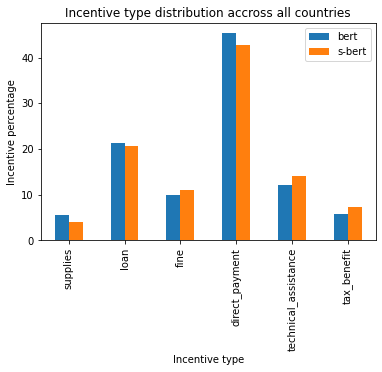

In [242]:
incentives_counts_perc_df.plot.bar(title="Incentive type distribution accross all countries", xlabel="Incentive type", ylabel="Incentive percentage")

Difference in labeling between both models - i.e BERT identifies 2276 more supplies than S-BERT, and S-BERT identifies 695 more tax_benefit than BERT

In [112]:
(incentives_counts_df["bert"] - incentives_counts_df["s-bert"])

supplies                2276
loan                    4095
fine                     577
direct_payment          9910
technical_assistance    -119
tax_benefit             -695
dtype: int64

Same calculation as before but in percentages i.e BERT identifies 1.38% more supplies than S-BERT, and S-BERT identifies 1.61% more tax_benefit than BERT

In [113]:
(incentives_counts_perc_df["bert"] - incentives_counts_perc_df["s-bert"])

supplies                1.381239
loan                    0.659770
fine                   -1.004608
direct_payment          2.615755
technical_assistance   -2.041503
tax_benefit            -1.610654
dtype: float64

**NOTE**: It would be interesting to see what each model labeled for the same sentence, for the sentences that are different. For example
1. Are the sentences labeled as "supplies" by BERT the same as the ones labeled by S-BERT? and viceversa
2. For the sentences labeled as "supplies" by BERT but NOT by S-BERT, what is the label that S-BERT gives? And viceversa

In [240]:
countries = df.country.unique()
countries

array(['El Salvador', 'Chile', 'Mexico', 'India', 'USA'], dtype=object)

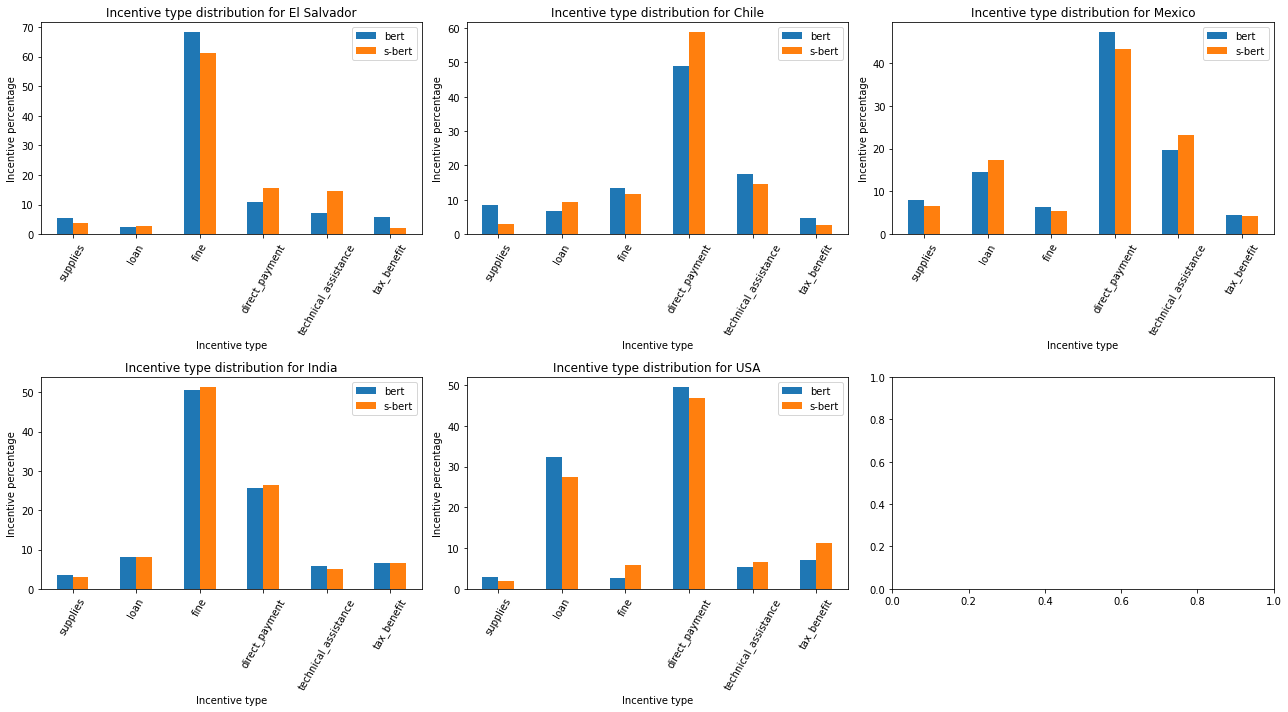

In [239]:
n_rows = 2
n_cols = 3

figure, axes = plt.subplots(n_rows, n_cols)
country_num = 0
for row in range(n_rows):
    for col in range(n_cols):
        if country_num < len(countries):
            country = countries[country_num]
            country_df = df[df["country"] == country]
            incentives_per_country = get_incentive_counts_df(country_df, perc=True)
            incentives_per_country.plot.bar(title=f"Incentive type distribution for {country}", xlabel="Incentive type", ylabel="Incentive percentage", ax=axes[row][col], figsize=(18,10), rot=60)
            country_num += 1
            
figure.tight_layout()

### Stats by country

**Galina**

Unique values / Attempt on standardization / Analysis

In [6]:
print(df['country'].value_counts())
print(df['pub lication_source'].value_counts())
#print(df['issuing_institution'].value_counts())

USA            14696
Mexico          5099
India           1126
Chile            860
El Salvador      460
Name: country, dtype: int64
Federal Register                   14696
Diario Oficial de la Federacion     5099
India Code                          1126
LeyChile                             860
Diario Oficial                       460
Name: pub lication_source, dtype: int64


In [7]:
#standardize dates
# date formats - Chile (2021-07-01), El Salvador (18/05/2021), Mexico (20-01-2011),
# India - (Acts) 2016-11-30, (Circular, Notification, Order, Ordinance, Regulation, Rule) - 08-03-2018, 
# USA - 18/05/2021

#some overrides first, otherwise format not recognised
#override

df["date"]=np.where((df["id"]=="863e4df1c50a88986125e1d5132791c80e4d70a5"),"14/12/1975",df["date"])


df_chi = df.loc[df.country == "Chile"]
df_chi["pub_date"]=pd.to_datetime(df_chi["date"], format="%Y/%m/%d")
df_salv = df.loc[df.country == "El Salvador"]
df_salv["pub_date"]=pd.to_datetime(df_salv["date"], format="%d/%m/%Y")
df_mex = df.loc[df.country == "Mexico"]
df_mex["pub_date"]=pd.to_datetime(df_mex["date"], format="%d-%m-%Y")
df_usa = df.loc[df.country == "USA"]
df_usa["pub_date"]=pd.to_datetime(df_usa["date"], format="%d/%m/%Y")
df_ind_a = df.loc[(df['country'] == "India") & (df['doc_type'] == "Act")]
df_ind_a["pub_date"]=pd.to_datetime(df_ind_a["date"], format="%Y/%m/%d")
df_ind_o=df.loc[(df['country'] == "India") & (df['doc_type'] != "Act")]
df_ind_o["pub_date"]=pd.to_datetime(df_ind_o["date"], format="%d/%m/%Y")


C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the c

In [8]:
df_all = pd.concat([df_salv, df_chi, df_mex, df_usa, df_ind_a, df_ind_o ])
#df_all.info()
df_all["Year"]=df_all["pub_date"].dt.year
df_year=df_all.Year.value_counts().sort_index(ascending=False)

#df_year
df_year_country=df_all.groupby(["country","Year"]).agg({"id":"count"})
df_year_country

id
country Year      
Chile   2011    70
        2012    69
        2013    64
        2014    73
        2015    88
...            ...
USA     2017  1245
        2018  1333
        2019  1314
        2020  1481
        2021   731

[140 rows x 1 columns]

In [9]:
df_country_inst=df_all.groupby(["country","issuing_institution"]).agg({"id":"count"})
df_country_inst

id
country issuing_institution                                   
Chile   GOBIERNO REGIONAL VI REGIÓN DEL LIBERTADOR GENE...   1
        MINISTERIO DE AGRICULTURA                           67
        MINISTERIO DE AGRICULTURA; SERVICILO AGRÍCOLA Y...   1
        MINISTERIO DE AGRICULTURA; SERVICIO AGRÍCOLA Y ...   2
        MINISTERIO DE AGRICULTURA; SERVICIO AGRÍCOLA Y ...  38
...                                                         ..
USA     SOCIAL SECURITY ADMINISTRATION                       6
        SURFACE TRANSPORTATION BOARD                        13
        SUSQUEHANNA RIVER BASIN COMMISSION                   3
        TENNESSEE VALLEY AUTHORITY                          10
        THE BUREAU OF CONSUMER FINANCIAL PROTECTION          1

[597 rows x 1 columns]

In [11]:
# split out doc type field - in some cases information about the category is there
# split on digits - to take the part without the reference

df_all["issuing_institution_clean"]=df_all["issuing_institution"].str.replace('(',';')


type_cat=df_all["doc_type"].str.split(r'(\d+)', n=1, expand=True)
df_all["type_cat"]=type_cat[0]

# replace the brackets with another sign otherwise messes up 
#df_all["issuing_institution_clean"]=df_all["issuing_institution"].str.replace('(',';')


# split out institution - on set punctuation - deal with brackets separately, as listing them results in error
inst_derived=df_all["issuing_institution_clean"].str.split(";|:|-|/", n=1, expand=True)
#inst_derived=df_all["issuing_institution"].str.split('(', n=1, expand=True)
#inst_derived=df_all["issuing_institution"].str.split(')', n=1, expand=True)
df_all["inst_derived_1"]=inst_derived[0].str.upper()
df_all["inst_derived_2"]=inst_derived[1].str.upper()

# # in cases of convocatorias the name is in the doc title - split on -

doc_title_split=df_all["doc_title"].str.split('-', n=1, expand=True)
df_all["doc_title_p1"]=doc_title_split[0]

In [12]:
# different patterns for each country - do separately

# El Salvador

df_salv_2 = df_all.loc[df_all.country == "El Salvador"]
#start with the default cause

df_salv_2['inst_final']=df_salv_2["inst_derived_2"]
# then if p2 not empty, take p2
df_salv_2['inst_final']=np.where((df_salv_2["inst_derived_2"].isna()),df_salv_2["inst_derived_1"],df_salv_2["inst_derived_2"])

# in some cases the name can be taken from the type, if part 2 empty
df_salv_2['inst_final']=np.where(((df_salv_2["inst_derived_2"].isna())&(df_salv_2["doc_type"].str.upper().str.contains('MUNICIPAL'))),"MUNICIPALIDAD",df_salv_2['inst_final'])

# trim and remove the closing brackets
df_salv_2["inst_final"]=df_salv_2["inst_final"].str.replace(')','').str.strip()

df_salv_2.inst_final.value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

ALCALDÍA MUNICIPAL                                                 201
MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES                   80
ALCALDIA MUNICIPAL                                                  42
MUNICIPALIDAD                                                       40
ORGANO LEGISLATIVO                                                  31
MINISTERIO DE AGRICULTURA Y GANADERÍA                               14
ALCALDÍAS MUNICIPALES                                               13
MINISTERIO DE SALUD                                                  6
PRESIDENCIA DE LA REPÚBLICA                                          3
MINISTERIO DE AGRICULTURA Y GANADERIA                                3
MINISTERIO DE ECONOMÍA                                               3
ORGANO EJECUTIVO                                                     3
MINISTERIO DE ECONOMIA                                               2
CORTE DE CUENTAS DE LA REPÚBLICA                                     2
PRESID

In [13]:
# map the different values


# Initialize dictionaru with multiple keys - use fromkeys
keys_set1 = ['ALCALDIA MUNICIPAL', 'ALCALDÍA MUNICIPAL', 'ALCALDÍAS MUNICIPALES', 'ALCLADIA MUNICIPAL','ALCADIA MUNICIPAL','ALCALDÍA MUNICIAPL','ALCALDIA MUNCIPAL','ALCALDIAS MUNICIPALES','ALCADÍA MUNICIPAL' ]
dict_set1 ={ **dict.fromkeys(keys_set1, 'ALCALDIA MUNICIPAL')} 
#  in place
df_salv_2.replace({"inst_final": dict_set1}, inplace=True)

# another set
keys_set2 = ['MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES', 'MINISTERIO DEL MEDIO AMBIENTE Y RECURSOS NATURALES', 'MINISTERIO DE MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES']
dict_set2 ={ **dict.fromkeys(keys_set2, 'MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES')} 
#  in place
df_salv_2.replace({"inst_final": dict_set2}, inplace=True)

# another set
keys_set3 = ['MINISTERIO DE AGRICULTURA Y GANADERÍA', 'MINISTERIO DE AGRICULTURA Y GANADERIA']
dict_set3 ={ **dict.fromkeys(keys_set3, 'MINISTERIO DE AGRICULTURA Y GANADERIA')} 
#  in place
df_salv_2.replace({"inst_final": dict_set3}, inplace=True)

# another set
keys_set4 = ['MINISTERIO DE ECONOMÍA', 'MINISTERIO DE ECONOMIA']
dict_set4 ={ **dict.fromkeys(keys_set4, 'MINISTERIO DE ECONOMIA')} 
#  in place
df_salv_2.replace({"inst_final": dict_set4}, inplace=True)

# another set
keys_set5 = ['PRESIDENCIA DE LA REPÚBLICA', 'PRESIDENCIA DE LA REPUBLICA']
dict_set5 ={ **dict.fromkeys(keys_set5, 'PRESIDENCIA DE LA REPUBLICA')} 
#  in place
df_salv_2.replace({"inst_final": dict_set5}, inplace=True)

# another set
keys_set5 = ['ORGANO EJECUTIVO', 'ÓRGANO EJECUTIVO']
dict_set5 ={ **dict.fromkeys(keys_set5, 'ORGANO EJECUTIVO')} 
#  in place
df_salv_2.replace({"inst_final": dict_set5}, inplace=True)


C:\Users\galiu\anaconda3\lib\site-packages\pandas\core\generic.py:6666: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regex=regex,


In [14]:
# now Chile
df_chi_2 = df_all.loc[df_all.country == "Chile"]

#start with the default cause
df_chi_2['inst_final']=df_chi_2["inst_derived_1"]

# group municipalities
df_chi_2['inst_final']=np.where((df_chi_2["inst_derived_1"].str.contains('MUNICIPALIDAD')),"MUNICIPALIDAD",df_chi_2['inst_final'])
df_chi_2['inst_final']=np.where((df_chi_2["inst_derived_1"].str.contains('GOBIERNO REGIONAL')),"GOBIERNO REGIONAL",df_chi_2['inst_final'])

df_chi_2.inst_final.value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.or

MINISTERIO DEL MEDIO AMBIENTE                            176
MINISTERIO DE ECONOMÍA, FOMENTO Y TURISMO                168
MINISTERIO DE AGRICULTURA                                135
MINISTERIO DE VIVIENDA Y URBANISMO                        57
MINISTERIO DE MINERÍA                                     53
MINISTERIO DE SALUD                                       52
MUNICIPALIDAD                                             43
MINISTERIO DE HACIENDA                                    36
MINISTERIO DE TRANSPORTES Y TELECOMUNICACIONES            25
MINISTERIO DE ENERGÍA                                     18
MINISTERIO DE RELACIONES EXTERIORES                       17
MINISTERIO DE JUSTICIA                                    17
MINISTERIO DE EDUCACIÓN                                   15
MINISTERIO DE OBRAS PÚBLICAS                              15
MINISTERIO DEL INTERIOR Y SEGURIDAD PÚBLICA                7
MINISTERIO DE DEFENSA NACIONAL                             5
MINISTERIO DEL TRABAJO Y

In [15]:
#  map the different values

# Initialize dictionaru with multiple keys - use fromkeys
keys_set1 = ['MINISTERIO DE ECONOMÍA,FOMENTO Y TURISMO', 'MINISTERIO DE ECONOMÍA, FOMENTO Y TURISMO' ]
dict_set1 ={ **dict.fromkeys(keys_set1, 'MINISTERIO DE ECONOMÍA, FOMENTO Y TURISMO')} 
#  in place
df_chi_2.replace({"inst_final": dict_set1}, inplace=True)

df_chi_2.inst_final.value_counts()

MINISTERIO DEL MEDIO AMBIENTE                            176
MINISTERIO DE ECONOMÍA, FOMENTO Y TURISMO                170
MINISTERIO DE AGRICULTURA                                135
MINISTERIO DE VIVIENDA Y URBANISMO                        57
MINISTERIO DE MINERÍA                                     53
MINISTERIO DE SALUD                                       52
MUNICIPALIDAD                                             43
MINISTERIO DE HACIENDA                                    36
MINISTERIO DE TRANSPORTES Y TELECOMUNICACIONES            25
MINISTERIO DE ENERGÍA                                     18
MINISTERIO DE RELACIONES EXTERIORES                       17
MINISTERIO DE JUSTICIA                                    17
MINISTERIO DE OBRAS PÚBLICAS                              15
MINISTERIO DE EDUCACIÓN                                   15
MINISTERIO DEL INTERIOR Y SEGURIDAD PÚBLICA                7
MINISTERIO DEL TRABAJO Y PREVISIÓN SOCIAL                  5
MINISTERIO DE DEFENSA NA

In [16]:
# now Mexico - in Mexico ministries are referred to as Secretarias.

df_mex_2 = df_all.loc[df_all.country == "Mexico"]

#start with the default cause
df_mex_2['inst_final']=df_mex_2["inst_derived_2"]


# if convocatorias type, replace with doc_title

# in some cases the name can be taken from the type, if part 2 empty
df_mex_2['inst_final']=np.where(((df_mex_2["inst_derived_2"].isna())&(df_mex_2["issuing_institution"].str.upper().str.contains('CONVOCATORIA'))),df_mex_2["doc_title_p1"].str.upper(),df_mex_2['inst_final'])


#df_mex_2.doc_title_p1.value_counts()
#df_mex_2.inst_derived_2.value_counts()
df_mex_2.inst_final.value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


SECRETARIA DE AGRICULTURA, GANADERIA, DESARROLLO RURAL, PESCA Y ALIMENTACION              1049
SECRETARIA DE MEDIO AMBIENTE Y RECURSOS NATURALES                                          431
SECRETARIA DE AGRICULTURA Y DESARROLLO RURAL                                               409
COMISION NACIONAL FORESTAL                                                                 234
SECRETARIA DE ECONOMIA                                                                     171
                                                                                          ... 
INSTITUTO MEXICANO DEL SEGURO SOCIAL                                                         1
SERVICIOS DE AGUA POTABLE, ALCANTARILLADO Y SANEAMIENTO DE MATEHUALA, SAN LUIS POTOSI        1
"ORGANIZACION DE USUARIOS DE RIEGO XAVIZENDE" A.C.                                           1
ASOCIACION DE USUARIOS DE LA UNIDAD DE RIEGO DE AUTLAN                                       1
SERVICIOS DE AGUA POTABLE ALCANTARILLADO Y SANEAMI

In [17]:
# convocatorias have lot of different sources 
# make tentative grouping - the ones mentioning estado; municipal; y riego (presumably) - they will be grouped later anyway under local

df_mex_2['inst_final']=np.where((df_mex_2['inst_final'].str.contains('MUNICIP'))&(df_mex_2["issuing_institution"].str.contains('CONVOCATORIA')),"SUB-FEDERAL",df_mex_2['inst_final'])

# categorise by keyword
df_mex_2['inst_final']=np.where((df_mex_2["inst_derived_1"].str.contains('CONVOCATORIA')&df_mex_2["inst_final"].str.contains("SANEAMIENTO")),"LOCAL-SANEAMIENTO",df_mex_2['inst_final'])
df_mex_2['inst_final']=np.where((df_mex_2["inst_derived_1"].str.contains('CONVOCATORIA')&df_mex_2["inst_final"].str.contains("RIEGO")),"LOCAL-RIEGO",df_mex_2['inst_final'])

# work for classifying sources still to  be done

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in

In [18]:
# for grouping - use lambdas with a list - group in a new field
# has not worked well - investigate why

list=['APOYOS Y SERVICIOS A LA COMERCIALIZACION AGROPECUARIA', 'BANCO DE MEXICO',
      'CENTRO DE INFRAESTRUCTURA Y DESARROLLO PARA LAS COMUNIDADES RURALES',
     'COLEGIO SUPERIOR AGROPECUARIO','COMISION NACIONAL FORESTAL','FONDO DE FOMENTO AGROPECUARIO','FIDEICOMISO DE FOMENTO MINERO',
     'FINANCIERA NACIONAL DE DESARROLLO AGROPECUARIO','FINANCIERA RURAL','FONDO DE FOMENTO AGROPECUARIO',
      'FONDO DE GARANTIA Y FOMENTO PARA LA AGRICULTURA','INSTITUTO ESTATAL DE ECOLOGIA Y DESARROLLO SUSTENTABLE',
     'INSTITUTO NACIONAL DE INVESTIGACIONES FORESTALES','PROCURADURIA AMBIENTAL Y DEL ORDENAMIENTO TERRITORIAL',
     'PROGRAMA NACIONAL DE FINANCIAMIENTO AL MICROEMPRESARIO Y A LA MUJER RURAL','PROMOTORA DEL DESARROLLO URBANO',
     'SECRETARIA DE AGRICULTURA','SECRETARIA DE DESARROLLO AGROPECUARIO','SECRETARIA DE DESARROLLO URBANO',
     'SECRETARIA DE ENERGIA RECURSOS NATURALES Y PROTECCION AMBIENTAL','SECRETARIA DE INFRAESTRUCTURA',
     'SECRETARIA DESARROLLO URBANO Y OBRAS','SECRETARIA DE SEGURIDAD','TRIBUNAL FEDERAL DE JUSTICIA ']
#y='AGRARIO'

# remove comas
df_mex_2['inst_final'] = df_mex_2['inst_final'].str.replace(",","")

for y in list:
    df_mex_2['inst_final'] = df_mex_2['inst_final'].apply(lambda x: y if y in x else x)



df_mex_2['inst_final'].value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


SECRETARIA DE AGRICULTURA                                                      1918
SECRETARIA DE MEDIO AMBIENTE Y RECURSOS NATURALES                               431
COMISION NACIONAL FORESTAL                                                      368
LOCAL-SANEAMIENTO                                                               235
SUB-FEDERAL                                                                     229
                                                                               ... 
SON                                                                               1
TAB                                                                               1
SERVICIO DE ADMINISTRACION Y ENAJENACION DE BIENES                                1
CONSEJO NACIONAL DE NORMALIZACION Y CERTIFICACION DE COMPETENCIAS LABORALES       1
INSTITUTO NACIONAL PARA EL DESARROLLO DE CAPACIDADES DEL SECTOR RURAL A.C.        1
Name: inst_final, Length: 72, dtype: int64

In [19]:
# now USA 

df_usa_2 = df_all.loc[df_all.country == "USA"]

#start with the default cause
df_usa_2['inst_final']=df_usa_2["issuing_institution_clean"].str.upper()

df_usa_2.inst_final.value_counts()


C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


ENVIRONMENTAL PROTECTION AGENCY                     2539
DEPARTMENT OF COMMERCE                              2333
DEPARTMENT OF THE INTERIOR                          2333
DEPARTMENT OF AGRICULTURE                           1899
DEPARTMENT OF TRANSPORTATION                         822
                                                    ... 
DENALI COMMISSION                                      1
HOUSING AND URBAN DEVELOPMENT                          1
BUREAU OF CONSUMER FINANANCIAL PROTECTION              1
ADMINISTRATIVE COMMITTEE OF THE FEDERAL REGISTER       1
DEPARTMENT OF THE INTEROR                              1
Name: inst_final, Length: 90, dtype: int64

In [20]:
# combine later - map the different values

# Initialize dictionaru with multiple keys - use fromkeys
keys_set1 = ['BUREAU OF CONSUMER FINANANCIAL PROTECTION', 'BUREAU OF CONSUMER FINANCIAL PROTECTION' ]
dict_set1 ={ **dict.fromkeys(keys_set1, 'BUREAU OF CONSUMER FINANCIAL PROTECTION')} 
#  in place
df_usa_2.replace({"inst_final": dict_set1}, inplace=True)

keys_set2 = ['DEPARTMENT OF THE INTERIOR', 'DEPARTMENT OF THE INTEROR' ]
dict_set2 ={ **dict.fromkeys(keys_set2, 'DEPARTMENT OF THE INTERIOR')} 
#  in place
df_usa_2.replace({"inst_final": dict_set2}, inplace=True)

keys_set3 = ['DEPARTMENT OF TRANSPORTATION', 'DEPARTMENT OF TRANSPORTATION [4910-EX-P]' ]
dict_set3 ={ **dict.fromkeys(keys_set3, 'DEPARTMENT OF TRANSPORTATION')} 
#  in place
df_usa_2.replace({"inst_final": dict_set3}, inplace=True)

keys_set4 = ['ENVIRONMENTAL PROTECTION AGENCY', 'ENVIRONMENTAL PROTECTION AGENCY REGION 8','EVIRONMENTAL PROTECTION AGENCY' ]
dict_set4 ={ **dict.fromkeys(keys_set4, 'ENVIRONMENTAL PROTECTION AGENCY')} 
#  in place
df_usa_2.replace({"inst_final": dict_set4}, inplace=True)

keys_set5 = ['NATIONAL AERONAUTICS AND SPACE ADMINISTRATION', 'NATIONAL AERONAUTICS AND SPACE ADMINSTRATION']
dict_set5 ={ **dict.fromkeys(keys_set5, 'NATIONAL AERONAUTICS AND SPACE ADMINISTRATION')} 
#  in place
df_usa_2.replace({"inst_final": dict_set5}, inplace=True)


df_usa_2.inst_final.value_counts()

ENVIRONMENTAL PROTECTION AGENCY                       2541
DEPARTMENT OF THE INTERIOR                            2334
DEPARTMENT OF COMMERCE                                2333
DEPARTMENT OF AGRICULTURE                             1899
DEPARTMENT OF TRANSPORTATION                           823
                                                      ... 
ADMINISTRATIVE COMMITTEE OF THE FEDERAL REGISTER         1
THE BUREAU OF CONSUMER FINANCIAL PROTECTION              1
MILLENNIUM CHALLENGE CORPORATION                         1
FEDERAL HIGHWAY ADMINISTRATION                           1
NATIONAL FOUNDATION ON THE ARTS AND THE HUMANITIES       1
Name: inst_final, Length: 84, dtype: int64

In [21]:
# now India - ministry, and if not available, department. two ministries are for regions - take the department instead 


df_ind_2 = df_all.loc[df_all.country == "India"]

#start with the default cause

df_ind_2['inst_final']=df_ind_2["inst_derived_1"]
# then if p2 not empty, take p2. ISNA not recognised, as the empty cells have some value, so ==""
df_ind_2['inst_final']=np.where((df_ind_2["inst_derived_1"]==""),df_ind_2["inst_derived_2"],df_ind_2["inst_derived_1"])
# in the cases of regional ministries take the department
df_ind_2['inst_final']=np.where((df_ind_2["inst_derived_1"].str.contains("MAHARASHTRA")),df_ind_2["inst_derived_2"],df_ind_2["inst_final"])
df_ind_2['inst_final']=np.where((df_ind_2["inst_derived_1"].str.contains(("ANDAMAN"))),df_ind_2["inst_derived_2"],df_ind_2["inst_final"])

# if empty - leave unknown and sort out later
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"].isna()),"UNKNOWN",df_ind_2["inst_final"].str.strip())



df_ind_2.inst_final.value_counts()


C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cave

UNKNOWN                                                                                    511
DEPARTMENT OF LAW                                                                           36
DEPARTMENT OF WATER RESOURCES DEPARTMENT                                                    36
DEPARTMENT OF LAW DEPARTMENT                                                                24
DEPARTMENT OF LABOUR AND WELFARE DEPARTMENT                                                 19
                                                                                          ... 
DEPARTMENT OF FISHERY DEPARTMENT                                                             1
DEPARTMENT OF HORTICULTURE                                                                   1
DEPARTMENT OF IRRIGATION AND FLOOD CONTROL ;IFCD) DEPARTMENT                                 1
DEPARTMENT OF AGRICULTURE DEPARTMENT, DAMAN                                                  1
DEPARTMENT OF AGRICULTURE, ANIMAL HUSBANDRY, DAIRY

In [22]:
# categorise by keyword the categories of interest

df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("PLANT"),"TITLE-PLANT PROTECTION",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("COIN"),"TITLE-COINAGE",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("IRRIGATION"),"TITLE-IRRIGATION",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("TEA"),"TITLE-TEA",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("POLLUTION"),"TITLE-POLLUTION",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("TELANGANA"),"TITLE-TELANGANA WOOD",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("AFFORESTATION"),"TITLE-AFFORESTATION",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("FOREST"),"TITLE-FOREST",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("GREEN TRIBUNAL"),"TITLE-GREEN TRIBUNAL",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("LAND ACQUISITION"),"TITLE-LAND ACQUISITION",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("SPICE"),"TITLE-SPICE",df_ind_2['inst_final'])
df_ind_2['inst_final']=np.where((df_ind_2["inst_final"]=='UNKNOWN')&df_ind_2["doc_title_p1"].str.upper().str.contains("WATER"),"TITLE-WATER",df_ind_2['inst_final'])


df_ind_2['inst_final'].value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try us

UNKNOWN                                                                                              291
TITLE-COINAGE                                                                                         57
TITLE-TEA                                                                                             37
DEPARTMENT OF WATER RESOURCES DEPARTMENT                                                              36
DEPARTMENT OF LAW                                                                                     36
                                                                                                    ... 
DEPARTMENT OF IRRIGATION                                                                               1
DEPARTMENT OF AGRICULTURE, ANIMAL HUSBANDRY AND CO-OPERATIVE  DEPARTMENT, GOVERNMENT OF JHARKHAND      1
DEPARTMENT OF LAND ACQUISITION  DEPARTMENT                                                             1
DEPARTMENT OF TOWN AND COUNTRY PLANNING DEPARTMENT, GOV

In [23]:
# combine values through lambdas

# for grouping - use lambdas with a list - group in a new field

list=['DEPARTMENT OF ADMINISTRATIVE REFORM','DEPARTMENT OF AGRICULTURE','DEPARTMENT OF ANIMAL HUSBANDRY',
      'DEPARTMENT OF ARCHAEOLOGY','DEPARTMENT OF CULTUR','DEPARTMENT OF ENVIRONMENT','DEPARTMENT OF FOREST',
      'DEPARTMENT OF FINANCE','DEPARTMENT OF FISHERIES','DEPARTMENT OF HOME','DEPARTMENT OF HORTICULTURE',
      'DEPARTMENT OF HOUSING','DEPARTMENT OF INDUSTR','DEPARTMENT OF IRRIGATION','DEPARTMENT OF WATER',
      'DEPARTMENT OF LABOUR','DEPARTMENT OF LAW','DEPARTMENT OF RURAL','DEPARTMENT OF REVENUE','DEPARTMENT OF PLANNING',
      'DEPARTMENT OF TOURISM','DEPARTMENT OF SOCIAL WELFARE','DEPARTMENT OF URBAN','DEPARTMENT OF HEALTH'
      'DEPARTMENT FOR WOMAN AND CHILD','DEPARTMENT FOR WOMEN CHILDREN','DEPARTMENT OF PANCHAYAT','DEPARTMENT OF PERSONNEL','DEPARTMENT OF TOWN',
      'DEPARTMENT OF LAND ACQUISITION','DEPARTMENT OF HANDLOOMS','MINISTRY OF AGRICULTURE','MINISTRY OF ENVIRONMENT','MINISTRY OF HOME']

# remove comas
df_ind_2['inst_final'] = df_ind_2['inst_final'].str.replace(",","")

for y in list:
    df_ind_2['inst_final'] = df_ind_2['inst_final'].apply(lambda x: y if y in x else x)



df_ind_2['inst_final'].value_counts()

C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\galiu\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


UNKNOWN                                                 291
DEPARTMENT OF LAW                                       101
TITLE-COINAGE                                            57
DEPARTMENT OF FOREST                                     50
DEPARTMENT OF REVENUE                                    47
                                                       ... 
DEPARTMENT OF ELECTRONICS AND INFORMATION TECHNOLOGY      1
MINISTRY OF COOPERATION                                   1
MINISTRY OF PUBLIC WORKS                                  1
MINISTRY OF TEXTILES                                      1
DEPARTMENT OF PARLIAMENTARY AFFAIRS DEPARTMENT            1
Name: inst_final, Length: 104, dtype: int64

In [24]:
df_all_2 = pd.concat([df_salv_2, df_chi_2, df_mex_2, df_usa_2, df_ind_2])

In [25]:
# now apply groups

df_all_2['inst_group']=df_all_2['inst_final']

# Use dictionary and replace - SET 1 - GENERAL PUBLIC SERVICES
inst_set1 = ['GOBIERNO REGIONAL','MINISTERIO DE HACIENDA','MINISTERIO DE RELACIONES EXTERIORES',
             'MINISTERIO SECRETARÍA GENERAL DE GOBIERNO','MINISTERIO SECRETARÍA GENERAL DE LA PRESIDENCIA','MUNICIPALIDAD',
             'ALCALDIA MUNICIPAL','CONSEJO DE ALCALDES DEL ÁREA METROPOLITANA DE SAN SALVADOR','CORTE DE CUENTAS DE LA REPÚBLICA',
             'MINISTERIO DE RELACIONES EXTERIORES','MUNICIPALIDAD','ORGANO EJECUTIVO','ORGANO LEGISLATIVO','PRESIDENCIA DE LA REPUBLICA',
             'DEPARTMENT OF ADMINISTRATIVE REFORM','DEPARTMENT OF ANDAMAN PUBLIC WORKS DEPARTMENT A & N ADMN','DEPARTMENT OF COLLECTOR DEPARTMENT',
             'DEPARTMENT OF COLONIZATION','DEPARTMENT OF FINANCE','DEPARTMENT OF GUWAHATI DEVELOPMENT DEPARTMENT',
             'DEPARTMENT OF LABOUR','DEPARTMENT OF LAND ACQUISITION','DEPARTMENT OF LOCAL SELF GOVERNMENT','DEPARTMENT OF MAHUD',
             'DEPARTMENT OF PARLIAMENTARY AFFAIRS DEPARTMENT','DEPARTMENT OF PERSONNEL','DEPARTMENT OF PHE;I&FC)',
             'DEPARTMENT OF PWD ;B&R)','DEPARTMENT OF REVENUE','DEPARTMENT OF SUPERINTENDENT ENGINEER PWD DAMAN','MINISTRY OF FINANCE',
             'MINISTRY OF REVENUE','TITLE-COINAGE','UNKNOWN','BANCO DE MEXICO','CAMARA DE DIPUTADOS',
             'CONSEJO NACIONAL DE NORMALIZACION Y CERTIFICACION DE COMPETENCIAS LABORALES','INSTITUTO MEXICANO DE LA PROPIEDAD INDUSTRIAL',
             'MEX','SECRETARIA DE GOBERNACION','SECRETARIA DE HACIENDA Y CREDITO PUBLICO','SECRETARIA DE LA FUNCION PUBLICA',
             'SECRETARIA DE RELACIONES EXTERIORES','SERVICIO DE ADMINISTRACION Y ENAJENACION DE BIENES','SON','SUB-FEDERAL',
             'TAB','ADMINISTRATIVE COMMITTEE OF THE FEDERAL REGISTER','ADMINISTRATIVE CONFERENCE OF THE UNITED STATES',
             'AGENCY FOR INTERNATIONAL DEVELOPMENT','COMMODITY FUTURES TRADING COMMISSION',
             'CORPORATION FOR NATIONAL AND COMMUNITY SERVICE','DENALI COMMISSION','DEPARTMENT OF LABOR','DEPARTMENT OF STATE',
             'DEPARTMENT OF THE TREASURY','DEPARTMENT OF TREASURY','EXECUTIVE OFFICE OF THE PRESIDENT',
             'FEDERAL FINANCIAL INSTITUTIONS EXAMINATION COUNCIL','FEDERAL LABOR RELATIONS AUTHORITY',
             'FEDERAL PERMITTING IMPROVEMENT STEERING COUNCIL','FEDERAL RESERVE SYSTEM','FEDERAL TRADE COMMISSION',
             'FINANCIAL STABILITY OVERSIGHT COUNCIL','GENERAL SERVICES ADMINISTRATION','INTERNATIONAL TRADE COMMISSION',
             'LIBRARY OF CONGRESS','MERIT SYSTEMS PROTECTION BOARD','MILLENNIUM CHALLENGE CORPORATION',
             'NATIONAL ARCHIVES AND RECORDS ADMINISTRATION','NATIONAL CAPITAL PLANNING COMMISSION',
             'NATIONAL CREDIT UNION ADMINISTRATION','NATIONAL LABOR RELATIONS BOARD','OFFICE OF MANAGEMENT AND BUDGET',
             'OFFICE OF PERSONNEL MANAGEMENT','OFFICE OF THE FEDERAL REGISTER','OFFICE OF THE UNITED STATES TRADE REPRESENTATIVE',
             'SECURITIES AND EXCHANGE COMMISSION','TENNESSEE VALLEY AUTHORITY']
dict_set1 ={ **dict.fromkeys(inst_set1, 'GENERAL PUBLIC SERVICES')} 
#  in place
df_all_2.replace({"inst_group": dict_set1}, inplace=True)

# Use dictionary and replace - SET 2 - DEFENCE
inst_set2 = ['MINISTERIO DE DEFENSA NACIONAL','MINISTRY OF DEFENCE','SECRETARIA DE MARINA',
             'DEFENSE NUCLEAR FACILITIES SAFETY BOARD','DEPARTMENT OF DEFENSE','DEPARTMENT OF HOMELAND SECURITY',
             'NATIONAL AERONAUTICS AND SPACE ADMINISTRATION']
dict_set2 ={ **dict.fromkeys(inst_set2, 'DEFENCE')} 
#  in place
df_all_2.replace({"inst_group": dict_set2}, inplace=True)

# Use dictionary and replace - SET 3 - PUBLIC ORDER AND SAFETY
inst_set3 = ['MINISTERIO DE JUSTICIA','MINISTERIO DE JUSTICIA Y DERECHOS HUMANOS','MINISTERIO DEL INTERIOR Y SEGURIDAD PÚBLICA',
             'DEPARTMENT OF HOME','DEPARTMENT OF LAW','DEPARTMENT OF POLICE DEPARTMENT','MINISTRY OF HOME','MINISTRY OF LAW AND JUSTICE',
             'MINISTRY OF LAW DEPARTMENT','PROCURADURIA GENERAL DE LA REPUBLICA','SECRETARIA DE SEGURIDAD','SUPREMA CORTE DE JUSTICIA DE LA NACION',
             'TRIBUNAL ELECTORAL DEL PODER JUDICIAL DE LA FEDERACION','TRIBUNAL FEDERAL DE JUSTICIA ','TRIBUNAL FEDERAL DE JUSTICIA ADMINISTRATIVA',
             'TRIBUNAL FEDERAL DE JUSTICIA FISCAL Y ADMINISTRATIVA','TRIBUNAL SUPERIOR AGRARIO','DEPARTMENT OF INTERIOR',
             'DEPARTMENT OF JUSTICE','DEPARTMENT OF THE INTERIOR','FEDERAL EMERGENCY MANAGEMENT AGENCY']
dict_set3 ={ **dict.fromkeys(inst_set3, 'PUBLIC ORDER AND SAFETY')} 
#  in place
df_all_2.replace({"inst_group": dict_set3}, inplace=True)

# Use dictionary and replace - SET 4 - ECONOMIC AFFAIRS
inst_set4 = ['MINISTERIO DE AGRICULTURA','MINISTERIO DE BIENES NACIONALES','MINISTERIO DE DESARROLLO SOCIAL',
             'MINISTERIO DE ECONOMÍA, FOMENTO Y TURISMO','MINISTERIO DE ENERGÍA','MINISTERIO DE MINERÍA',
             'MINISTERIO DE TRANSPORTES Y TELECOMUNICACIONES','MINISTERIO DE AGRICULTURA Y GANADERIA',
             'MINISTERIO DE ECONOMIA','SUPERINTENDENCIA GENERAL DE ELECTRICIDAD Y TELECOMUNICACIONES',
             'DEPARTMENT OF AGRICULTURE','DEPARTMENT OF ANIMAL AND SHEEP HUSBANDARY','DEPARTMENT OF ANIMAL HUSBANDRY',
             'DEPARTMENT OF COMMERCE & INDUSTRIES DEPARTMENT','DEPARTMENT OF CO-OPERATION MARKETING AND TEXTILES DEPARTMENT',
             'DEPARTMENT OF ECONOMICS & STATISTICS','DEPARTMENT OF ELECTRONICS AND INFORMATION TECHNOLOGY',
             'DEPARTMENT OF FARMER WELFARE AND AGRICULTURE DEVELOPMENT DEPARTMENT','DEPARTMENT OF FISHERIES',
             'DEPARTMENT OF FISHERY DEPARTMENT','DEPARTMENT OF FLORICULTURE','DEPARTMENT OF FOOD SECURITY AND AGRICULTURE DEVELOPMENT DEPARTMENT',
             'DEPARTMENT OF HORTICULTURE','DEPARTMENT OF INDUSTR','DEPARTMENT OF LIVESTOCK DEVELOPMENT','DEPARTMENT OF TOURISM',
             'DEPARTMENT OF TRANSPORT','MINISTRY OF AGRICULTURE','MINISTRY OF ANIMAL HUSBANDRY','MINISTRY OF COAL',
             'MINISTRY OF COMMERCE AND INDUSTRY','MINISTRY OF COOPERATION','MINISTRY OF HORTICULTURE','MINISTRY OF INDUSTRIES',
             'MINISTRY OF RAILWAYS','MINISTRY OF TEXTILES','TITLE-SPICE','TITLE-TEA','COMISION FEDERAL DE COMPETENCIA ECONOMICA',
             'COMISION NACIONAL DE HIDROCARBUROS','COMISION REGULADORA DE ENERGIA','FIDEICOMISO DE FOMENTO MINERO',
             'FIDEICOMISOS INSTITUIDOS EN RELACION CON LA AGRICULTURA','FINANCIERA NACIONAL DE DESARROLLO AGROPECUARIO',
             'FINANCIERA RURAL','FONDO DE CAPITALIZACION E INVERSION DEL SECTOR RURAL ','FONDO DE FOMENTO AGROPECUARIO',
             'FONDO DE GARANTIA Y FOMENTO PARA LA AGRICULTURA','INSTITUTO NACIONAL DE ESTADISTICA Y GEOGRAFIA','LOCAL-RIEGO',
             'PROCURADURIA AGRARIA','SECRETARIA DE AGRICULTURA','SECRETARIA DE COMUNICACIONES Y TRANSPORTES',
             'SECRETARIA DE DESARROLLO AGROPECUARIO','SECRETARIA DE ECONOMIA','SECRETARIA DE ENERGIA',
             'SECRETARIA DE LA REFORMA AGRARIA','CONSUMER PRODUCT SAFETY COMMISSION','DEPARMENT OF ENERGY','DEPARTMENT OF AGRICULTURE',
             'DEPARTMENT OF COMMERCE','DEPARTMENT OF ENERGY','DEPARTMENT OF TRANSPORTATION','EXPORT-IMPORT BANK',
             'FARM CREDIT ADMINISTRATION','FARM CREDIT SYSTEM INSURANCE CORPORATION','FEDERAL COMMUNICATIONS COMMISSION',
             'FEDERAL DEPOSIT INSURANCE CORPORATION','FEDERAL HIGHWAY ADMINISTRATION','FEDERAL MARITIME COMMISSION',
             'FEDERAL MINE SAFETY AND HEALTH REVIEW COMMISSION','NATIONAL TRANSPORTATION SAFETY BOARD','NUCLEAR REGULATORY COMMISSION',
             'PACIFIC NORTHWEST ELECTRIC POWER AND CONSERVATION PLANNING COUNCIL','POSTAL REGULATORY COMMISSION','POSTAL SERVICE',
             'RAILROAD RETIREMENT BOARD','SMALL BUSINESS ADMINISTRATION','SURFACE TRANSPORTATION BOARD']
dict_set4 ={ **dict.fromkeys(inst_set4, 'ECONOMIC AFFAIRS')} 
#  in place
df_all_2.replace({"inst_group": dict_set4}, inplace=True)

# Use dictionary and replace - SET 5 - ENVIRONMENTAL PROTECTION
inst_set5 = ['MINISTERIO DEL MEDIO AMBIENTE','MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES',
             'MINISTERIO DEL MEDIO AMBIENTE','DEPARTMENT OF CHANDIGARH POLLUTION CONTROL COMMITTEE',
             'DEPARTMENT OF ENVIRONMENT','DEPARTMENT OF FOREST','MINISTRY OF ENVIRONMENT','MINISTRY OF FOREST',
             'TITLE-PLANT PROTECTION','TITLE-AFFORESTATION','TITLE-FOREST','TITLE-GREEN TRIBUNAL','TITLE-POLLUTION',
             'TITLE-TELANGANA WOOD','COMISION NACIONAL FORESTAL','COMISION NACIONAL PARA EL DESARROLLO DE LOS PUEBLOS INDIGENAS',
             'INSTITUTO DE IMPACTO Y RIESGO AMBIENTAL DEL ESTADO DE QUINTANA ROO ','INSTITUTO ESTATAL DE ECOLOGIA Y DESARROLLO SUSTENTABLE',
             'INSTITUTO FEDERAL ELECTORAL','INSTITUTO NACIONAL DE ECOLOGIA Y CAMBIO CLIMATICO',
             'INSTITUTO NACIONAL DE INVESTIGACIONES FORESTALES','INSTITUTO NACIONAL DEL SUELO SUSTENTABLE ',
             'PROCURADURIA AMBIENTAL Y DEL ORDENAMIENTO TERRITORIAL','PROTECTORA DE BOSQUES DEL ESTADO DE MEXICO ',
             'SECRETARIA DE ENERGIA RECURSOS NATURALES Y PROTECCION AMBIENTAL','SECRETARIA DE MEDIO AMBIENTE Y RECURSOS NATURALES',
             'COUNCIL ON ENVIRONMENTAL QUALITY','ENVIRONMENTAL PROTECTION AGENCY','GULF COAST ECOSYSTEM RESTORATION COUNCIL',
             'SUSQUEHANNA RIVER BASIN COMMISSION']
dict_set5 ={ **dict.fromkeys(inst_set5, 'ENVIRONMENTAL PROTECTION')} 
#  in place
df_all_2.replace({"inst_group": dict_set5}, inplace=True)

# Use dictionary and replace - SET 6 - HOUSING AND COMMUNITY AMENITIES
inst_set6 = ['MINISTERIO DE OBRAS PÚBLICAS','MINISTERIO DE VIVIENDA Y URBANISMO','DEPARTMENT OF HOUSING',
             'DEPARTMENT OF IRRIGATION','DEPARTMENT OF NARMADA WATER RESOURCES WATER SUPPLY AND KALPSAR DEPARTMENT',
             'DEPARTMENT OF PANCHAYAT','DEPARTMENT OF PLANNING','DEPARTMENT OF RURAL','DEPARTMENT OF SCHEDULED TRIBES DEPT',
             'DEPARTMENT OF TOWN','DEPARTMENT OF URBAN','DEPARTMENT OF WATER','MINISTRY OF HOUSING AND URBAN AFFAIRS',
             'MINISTRY OF PLANNING','MINISTRY OF PUBLIC WORKS','MINISTRY OF RURAL DEVELOPMENT','MINISTRY OF TOWN AND COUNTRY PLANNING',
             'TITLE-IRRIGATION','TITLE-LAND ACQUISITION','TITLE-WATER','APOYOS Y SERVICIOS A LA COMERCIALIZACION AGROPECUARIA',
             'CENTRO DE INFRAESTRUCTURA Y DESARROLLO PARA LAS COMUNIDADES RURALES','INSTITUTO NACIONAL PARA EL DESARROLLO DE CAPACIDADES DEL SECTOR RURAL A.C. ',
             'LOCAL-SANEAMIENTO','PROMOTORA DEL DESARROLLO URBANO','SECRETARIA DE DESARROLLO AGRARIO TERRITORIAL Y URBANO',
             'SECRETARIA DE DESARROLLO URBANO','SECRETARIA DE INFRAESTRUCTURA','SECRETARIA DE OBRAS PUBLICAS Y DESARROLLO URBANO ',
             'SECRETARIA DESARROLLO URBANO Y OBRAS','DEPARTMENT OF HOUSING AND URBAN DEVELOPMENT','FEDERAL HOUSING FINANCE AGENCY',
             'HOUSING AND URBAN DEVELOPMENT']
dict_set6 ={ **dict.fromkeys(inst_set6, 'HOUSING AND COMMUNITY AMENITIES')} 
#  in place
df_all_2.replace({"inst_group": dict_set6}, inplace=True)

# Use dictionary and replace - SET 7 - HEALTH
inst_set7 = ['MINISTERIO DE SALUD','MINISTERIO DE SALUD','DEPARTMENT OF GOVERNMENT MEDICAL COLLEGE & HOSPITAL CHANDIGARH-32',
             'DEPARTMENT OF RELIEF AND REHABILITATION DEPARTMENT','SECRETARIA DE SALUD','SEGURIDAD ALIMENTARIA MEXICANA ','DEPARTMENT OF HEALTH AND HUMAN SERVICES',
             'OCCUPATIONAL SAFETY AND HEALTH REVIEW COMMISSION']
dict_set7 ={ **dict.fromkeys(inst_set7, 'HEALTH')} 
#  in place
df_all_2.replace({"inst_group": dict_set7}, inplace=True)

# Use dictionary and replace - SET 8 - RECREATION, CULTURE AND RELIGION
inst_set8 = ['MINISTERIO DE LAS CULTURAS, LAS ARTES Y EL PATRIMONIO','DEPARTMENT OF ARCHAEOLOGY',
             'DEPARTMENT OF ART CULTURE AND LANGUAGE DEPARTMENT','DEPARTMENT OF CULTUR','DEPARTMENT OF HANDLOOMS',
             'DEPARTMENT OF KANNADA CULTURE INFORMATION & TOURISM DEPARTMENT',
             'DEPARTMENT OF YOUTH ADVANCEMENT TOURISM AND CULTURE','MINISTRY OF CULTURE','MINISTRY OF INFORMATION AND BROADCASTING',
             'MINISTRY OF LANGUAGE ART AND CULTURE','SECRETARIA DE CULTURA','AMERICAN BATTLE MONUMENTS COMMISSION',
             'NATIONAL FOUNDATION ON THE ARTS AND THE HUMANITIES']
dict_set8 ={ **dict.fromkeys(inst_set8, 'RECREATION, CULTURE AND RELIGION')} 
#  in place
df_all_2.replace({"inst_group": dict_set8}, inplace=True)

# Use dictionary and replace - SET 9 - EDUCATION
inst_set9 = ['MINISTERIO DE EDUCACIÓN','DEPARTMENT OF SCIENCE & TECHNOLOGY DEPARTMENT GOVERNMENT OF GOA.',
             'COLEGIO SUPERIOR AGROPECUARIO','SECRETARIA DE EDUCACION PUBLICA','DEPARTMENT OF EDUCATION',
             'NATIONAL SCIENCE FOUNDATION','OFFICE OF SCIENCE AND TECHNOLOGY POLICY']
dict_set9 ={ **dict.fromkeys(inst_set9, 'EDUCATION')} 
#  in place
df_all_2.replace({"inst_group": dict_set9}, inplace=True)

# Use dictionary and replace - SET 10 - SOCIAL PROTECTION
inst_set10 = ['MINISTERIO DE DESARROLLO SOCIAL Y FAMILIA','MINISTERIO DEL TRABAJO Y PREVISIÓN SOCIAL',
              'MINISTERIO DE TRABAJO Y PREVISIÓN SOCIAL','DEPARTMENT FOR WOMEN CHILDREN','DEPARTMENT OF EMPOWERMENT OF PERSONS WITH DISABILITIES',
              'DEPARTMENT OF HEALTH & FAMILY WELFARE DEPARTMENT','DEPARTMENT OF SOCIAL JUSTICE EMPOWERMENT DEPARTMENT',
              'DEPARTMENT OF SOCIAL WELFARE','DEPARTMENT OF TRIBAL WELFARE','DEPARTMENT OF WOMAN AND CHILD DEVELOPMENT',
              'DEPARTMENT OF WOMEN AND CHILD DEVELOPMENT DEPARTMENT','INSTITUTO MEXICANO DEL SEGURO SOCIAL',
              'INSTITUTO NACIONAL DE LOS PUEBLOS INDIGENAS','PROGRAMA NACIONAL DE FINANCIAMIENTO AL MICROEMPRESARIO Y A LA MUJER RURAL',
              'SECRETARIA DE BIENESTAR','SECRETARIA DE DESARROLLO SOCIAL','SECRETARIA DEL TRABAJO Y PREVISION SOCIAL',
              'BUREAU OF CONSUMER FINANCIAL PROTECTION','COMMITTEE FOR PURCHASE FROM PEOPLE WHO ARE BLIND OR SEVERELY DISABLED',
              'CONSUMER FINANCIAL PROTECTION BUREAU','DEPARTMENT OF VETERANS AFFAIRS','NATIONAL INDIAN GAMING COMMISSION',
              'PENSION BENEFIT GUARANTY CORPORATION','SOCIAL SECURITY ADMINISTRATION','THE BUREAU OF CONSUMER FINANCIAL PROTECTION']
dict_set10 ={ **dict.fromkeys(inst_set10, 'SOCIAL PROTECTION')} 
#  in place
df_all_2.replace({"inst_group": dict_set10}, inplace=True)

df_all_2['inst_group'].value_counts()

ECONOMIC AFFAIRS                    10094
ENVIRONMENTAL PROTECTION             4006
PUBLIC ORDER AND SAFETY              2653
GENERAL PUBLIC SERVICES              2506
HOUSING AND COMMUNITY AMENITIES       957
DEFENCE                               851
HEALTH                                474
SOCIAL PROTECTION                     461
EDUCATION                             210
RECREATION, CULTURE AND RELIGION       29
Name: inst_group, dtype: int64

In [26]:
# create count markers for incentives
# set the index first

df_all_2=df_all_2.set_index("id")

df_all_2.head()

,country,pub lication_source,issuing_institution,doc_type,date,doc_title,summary,url,num_sents,min_sent_len,...,tax_benefit_bert,pub_date,Year,type_cat,issuing_institution_clean,inst_derived_1,inst_derived_2,doc_title_p1,inst_final,inst_group
id,,,,,,,,,,,,,,,,,,,,,
765d4ea2383aaf45bb29bf75feadea6e06a80fd2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Tamanique,27/01/2015,ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,"La presente Ordenanza tiene por objeto, promov...",https://www.jurisprudencia.gob.sv/DocumentosBo...,315,27,...,5,2015-01-27,2015,Decreto Municipal-Tamanique,INSTITUCIONES AUTÓNOMAS ;Alcaldía Municipal),INSTITUCIONES AUTÓNOMAS,ALCALDÍA MUNICIPAL),ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,ALCALDIA MUNICIPAL,GENERAL PUBLIC SERVICES
06dafc0a507e270d9b23b192489cb1012aed1a8f,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,01/02/2018,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,28,66,...,0,2018-02-01,2018,Decreto Ejecutivo,ORGANO EJECUTIVO ;Ministerio de Medio Ambiente...,ORGANO EJECUTIVO,MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURA...,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES,ENVIRONMENTAL PROTECTION
3416cbf9af02b66c40c8ee6f6aa5988ba680dcb2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Jocoro,21/08/2017,ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,La presente ordenanza tiene por objeto estable...,https://www.jurisprudencia.gob.sv/DocumentosBo...,228,30,...,1,2017-08-21,2017,Decreto Municipal-Jocoro,INSTITUCIONES AUTÓNOMAS ;Alcaldía Municipal),INSTITUCIONES AUTÓNOMAS,ALCALDÍA MUNICIPAL),ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,ALCALDIA MUNICIPAL,GENERAL PUBLIC SERVICES
485f9571c67f4a8009dd340bc5905f56a767b400,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,08/10/2014,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,30,75,...,0,2014-10-08,2014,Decreto Ejecutivo,ORGANO EJECUTIVO ;Ministerio de Medio Ambiente...,ORGANO EJECUTIVO,MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURA...,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,MINISTERIO DE MEDIO AMBIENTE Y RECURSOS NATURALES,ENVIRONMENTAL PROTECTION
2c1449a52f077b5b0d61471a55601f0a316be1a9,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-San José Villanueva,06/09/2012,ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,El objeto de la presente Ordenanza es el de no...,https://www.jurisprudencia.gob.sv/DocumentosBo...,29,36,...,2,2012-09-06,2012,Decreto Municipal-San José Villanueva,INSTITUCIONES AUTÓNOMAS ;Alcaldía Municipal),INSTITUCIONES AUTÓNOMAS,ALCALDÍA MUNICIPAL),ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,ALCALDIA MUNICIPAL,GENERAL PUBLIC SERVICES


In [27]:
### define function and apply to new fields

def count_marker(x):
    if (x)*1>0:
        return 1
    else:
        return 0
    
    

list= ["num_incentives_sbert", "supplies_sbert",
            "loan_sbert", "fine_sbert", "direct_payment_sbert", "technical_assistance_sbert", "tax_benefit_sbert",
            "num_incentives_bert", "supplies_bert", "loan_bert", "fine_bert", "direct_payment_bert", "technical_assistance_bert",
            "tax_benefit_bert"]

# create new columns
for y in list:
    df_all_2[y+'_YN'] = df_all_2[y]



for y in list:
    df_all_2[y+'_YN']=df_all_2[y+'_YN'].apply(count_marker)


        
df_all_2     

,country,pub lication_source,issuing_institution,doc_type,date,doc_title,summary,url,num_sents,min_sent_len,...,direct_payment_sbert_YN,technical_assistance_sbert_YN,tax_benefit_sbert_YN,num_incentives_bert_YN,supplies_bert_YN,loan_bert_YN,fine_bert_YN,direct_payment_bert_YN,technical_assistance_bert_YN,tax_benefit_bert_YN
id,,,,,,,,,,,,,,,,,,,,,
765d4ea2383aaf45bb29bf75feadea6e06a80fd2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Tamanique,27/01/2015,ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,"La presente Ordenanza tiene por objeto, promov...",https://www.jurisprudencia.gob.sv/DocumentosBo...,315,27,...,1,0,1,1,1,1,1,1,1,1
06dafc0a507e270d9b23b192489cb1012aed1a8f,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,01/02/2018,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,28,66,...,0,0,0,1,1,0,0,0,0,0
3416cbf9af02b66c40c8ee6f6aa5988ba680dcb2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Jocoro,21/08/2017,ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,La presente ordenanza tiene por objeto estable...,https://www.jurisprudencia.gob.sv/DocumentosBo...,228,30,...,1,1,1,1,1,0,1,0,1,1
485f9571c67f4a8009dd340bc5905f56a767b400,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,08/10/2014,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,30,75,...,0,0,0,0,0,0,0,0,0,0
2c1449a52f077b5b0d61471a55601f0a316be1a9,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-San José Villanueva,06/09/2012,ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,El objeto de la presente Ordenanza es el de no...,https://www.jurisprudencia.gob.sv/DocumentosBo...,29,36,...,1,0,0,1,0,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1df2c9c33ba6a3aa53382b38591b4adc5218ef21,India,India Code,NaN,Notification,15/04/2019,Under Section 3 (h) Commissioner for Rehabilit...,NaN,https://upload.indiacode.nic.in/showfile?actid...,13,33,...,0,0,0,0,0,0,0,0,0,0
4d47a7790fa4fd4a4e20784f9233ed5770a1dfbc,India,India Code,NaN,Notification,11/12/2019,Sub - Section 1 of 11 the right of fair compen...,NaN,https://upload.indiacode.nic.in/showfile?actid...,18,37,...,0,0,0,0,0,0,0,0,0,0
676d9337f12880e629623c3f9b12a846e0404edd,India,India Code,NaN,Notification,26/09/2019,Under Section 11 Right to fair compensation an...,NaN,https://upload.indiacode.nic.in/showfile?actid...,201,21,...,1,0,0,1,0,0,1,1,0,0


In [28]:
# get a marker for non-incentive document - neither bert nor sbert incentives

df_all_2['non_incentive_doc'] = np.where((df_all_2['num_incentives_sbert']+df_all_2['num_incentives_bert']==0),'Yes', 'No')
df_all_2['sber_bert_incentive_doc'] = np.where((df_all_2['num_incentives_sbert_YN']+df_all_2['num_incentives_bert_YN']==2),'Yes', 'No')
# need another way to define the below types, as 0 not recognised as integer but as NA
df_all_2['sbert_only_incentive_doc'] = np.where((df_all_2['num_incentives_sbert_YN']>df_all_2['num_incentives_bert_YN']),'Yes', 'No')
df_all_2['bert_only_incentive_doc'] = np.where((df_all_2['num_incentives_bert_YN']>df_all_2['num_incentives_sbert_YN']),'Yes', 'No')

#df_all_2.bert_only_incentive_doc.nunique()

In [29]:
# sum of different incentives

df_all_2["num_unique_incentives_sbert"]=df_all_2["supplies_sbert_YN"]+df_all_2["loan_sbert_YN"]+df_all_2["fine_sbert_YN"]+df_all_2["direct_payment_sbert_YN"]+df_all_2["technical_assistance_sbert_YN"]+df_all_2["tax_benefit_sbert_YN"]
df_all_2["num_unique_incentives_bert"]=df_all_2["supplies_bert_YN"]+df_all_2["loan_bert_YN"]+df_all_2["fine_bert_YN"]+df_all_2["direct_payment_bert_YN"]+df_all_2["technical_assistance_bert_YN"]+df_all_2["tax_benefit_bert_YN"]
df_all_2.head()

,country,pub lication_source,issuing_institution,doc_type,date,doc_title,summary,url,num_sents,min_sent_len,...,fine_bert_YN,direct_payment_bert_YN,technical_assistance_bert_YN,tax_benefit_bert_YN,non_incentive_doc,sber_bert_incentive_doc,sbert_only_incentive_doc,bert_only_incentive_doc,num_unique_incentives_sbert,num_unique_incentives_bert
id,,,,,,,,,,,,,,,,,,,,,
765d4ea2383aaf45bb29bf75feadea6e06a80fd2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Tamanique,27/01/2015,ORDENANZA REGULADORA DE USOS DE SUELO Y ACTUAC...,"La presente Ordenanza tiene por objeto, promov...",https://www.jurisprudencia.gob.sv/DocumentosBo...,315,27,...,1,1,1,1,No,Yes,No,No,5,6
06dafc0a507e270d9b23b192489cb1012aed1a8f,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,01/02/2018,DECRETO POR MEDIO DEL CUAL SE ESTABLECE COMO A...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,28,66,...,0,0,0,0,No,No,No,Yes,0,1
3416cbf9af02b66c40c8ee6f6aa5988ba680dcb2,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-Jocoro,21/08/2017,ORDENANZA REGULADORA DE LOS RESIDUOS SOLIDOS D...,La presente ordenanza tiene por objeto estable...,https://www.jurisprudencia.gob.sv/DocumentosBo...,228,30,...,1,0,1,1,No,Yes,No,No,5,4
485f9571c67f4a8009dd340bc5905f56a767b400,El Salvador,Diario Oficial,ORGANO EJECUTIVO (Ministerio de Medio Ambiente...,Decreto Ejecutivo,08/10/2014,DECRETO POR MEDIO DEL CUAL SE ESTABLECE AREA N...,El presente Decreto tiene como objetivos conse...,https://www.jurisprudencia.gob.sv/DocumentosBo...,30,75,...,0,0,0,0,Yes,No,No,No,0,0
2c1449a52f077b5b0d61471a55601f0a316be1a9,El Salvador,Diario Oficial,INSTITUCIONES AUTÓNOMAS (Alcaldía Municipal),Decreto Municipal-San José Villanueva,06/09/2012,ORDENANZA DE CONTRIBUCION ESPECIAL DE INSTALAC...,El objeto de la presente Ordenanza es el de no...,https://www.jurisprudencia.gob.sv/DocumentosBo...,29,36,...,1,1,0,1,No,Yes,No,No,2,3


In [30]:
# next - visualisations
# correlation matrix - incentives count
# correlation matrix - juris areas count
#time-series - incentive docs by year, incentive institution areas by year (docs with incentive only)
# proportion of useful docs
# sbert and bert comparison
# etc